In [1]:
import pandas as pd
import os
import pickle
import torch
import numpy as np
import IPython.display as ipd

sub_dev = pd.read_csv('/Users/vigi99/AirtelDEV/MixMatch-pytorch/submission/submission_split_train_dev.csv', index_col='fname')
t_dev = pd.read_csv('/Users/vigi99/AirtelDEV/MixMatch-pytorch/data/freesound/train_curated.csv_dev', index_col='fname')
t_test = pd.read_csv('/Users/vigi99/AirtelDEV/MixMatch-pytorch/data/freesound/train_curated.csv_test', index_col='fname')
t_train = pd.read_csv('/Users/vigi99/AirtelDEV/MixMatch-pytorch/data/freesound/train_curated.csv_train', index_col='fname')
target_dev = pd.concat([t_dev, t_test])
lb = pickle.load(open('/Users/vigi99/AirtelDEV/MixMatch-pytorch/result/lb.pk' , 'rb'))
test_path = os.path.abspath('/Users/vigi99/kaggle/freesound/data/train_curated')
join_df = sub_dev.join(target_dev)

In [2]:
target_labels = lb.transform([label.split(',') for label in join_df['labels'].values])
predicted_labels = join_df[lb.classes_].values

In [3]:
import sys
sys.path.append(os.path.abspath('../utils'))
from eval import lwlrap_accumulator

lacc = lwlrap_accumulator()
lacc.accumulate_samples(torch.tensor(target_labels), torch.tensor(predicted_labels))

In [4]:
labels = np.array(lb.classes_)
scores = np.array(lacc.per_class_lwlrap())
num_examples = np.array(lacc._per_class_cumulative_count)
idx = np.argsort(scores)
sorted_labels = labels[idx].tolist()
sorted_scores = scores[idx].tolist()
sorted_numexamples = num_examples[idx].tolist()
for label, score, num_example in zip(sorted_labels, sorted_scores, sorted_numexamples):
    print(f"{label} = {score} with num of samples {num_example}")

Hiss = 0.2692307692307692 with num of samples 2
Computer_keyboard = 0.3451388888888889 with num of samples 4
Keys_jangling = 0.44791666666666663 with num of samples 4
Zipper_(clothing) = 0.47023809523809523 with num of samples 7
Tap = 0.5606060606060606 with num of samples 6
Walk_and_footsteps = 0.593095238095238 with num of samples 10
Gasp = 0.632034632034632 with num of samples 7
Squeak = 0.6367424242424242 with num of samples 8
Fill_(with_liquid) = 0.6854166666666666 with num of samples 8
Female_singing = 0.7061224489795919 with num of samples 7
Fart = 0.7135416666666666 with num of samples 6
Bathtub_(filling_or_washing) = 0.7181372549019608 with num of samples 6
Meow = 0.7365384615384616 with num of samples 11
Buzz = 0.7461028192371476 with num of samples 9
Cutlery_and_silverware = 0.7471264367816092 with num of samples 5
Yell = 0.75 with num of samples 6
Waves_and_surf = 0.75 with num of samples 9
Writing = 0.7569444444444444 with num of samples 10
Slam = 0.7577160493827161 with n

In [5]:
def get_examples(df, classname):
    return df[df.labels.str.contains(classname)]

def labels_values(df, lb, classname):
    predicted_labels = df.sample(1)[lb.classes_]
    file_path = os.path.join(test_path, predicted_labels.index.values[0])
    print(f"file was {file_path}")
    top_5 = np.argsort(predicted_labels.values[0])[-5:].tolist()
    top_5.reverse()
    print(np.array(predicted_labels.columns)[top_5])
    print(np.array(predicted_labels.values)[0][top_5])
    print(f"Value for {classname} was {predicted_labels[classname].values[0]}")
    return file_path

classname = "Meow"
example_for_class = get_examples(join_df, classname)
file_path = labels_values(example_for_class, lb, classname)
ipd.Audio(file_path)

file was /Users/vigi99/kaggle/freesound/data/train_curated/c7089ee9.wav
['Child_speech_and_kid_speaking' 'Meow' 'Traffic_noise_and_roadway_noise'
 'Hiss' 'Chirp_and_tweet']
[0.55593592 0.44504046 0.24294339 0.14095375 0.13868237]
Value for Meow was 0.4450404644012451


In [6]:
example_hiss = get_examples(t_train, classname).sample(1)
example_train_path = os.path.join(test_path, example_hiss.index.values[0])
print(example_hiss)
ipd.Audio(example_train_path)

             labels
fname              
eaf579a5.wav   Meow


In [7]:
from torchvision.transforms import Compose
import sys
sys.path.append(os.path.abspath('..'))
from kaggle_submission_checker import *

valid_transforms = Compose([LoadAudio(), FixAudioLength(30), ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=80)])
stft_transforms = Compose([LoadAudio(), FixAudioLength(30), ToSTFT()])
test_mel = valid_transforms(file_path)
train_mel = valid_transforms(example_train_path)

Text(0.5, 1.0, 'train mel')

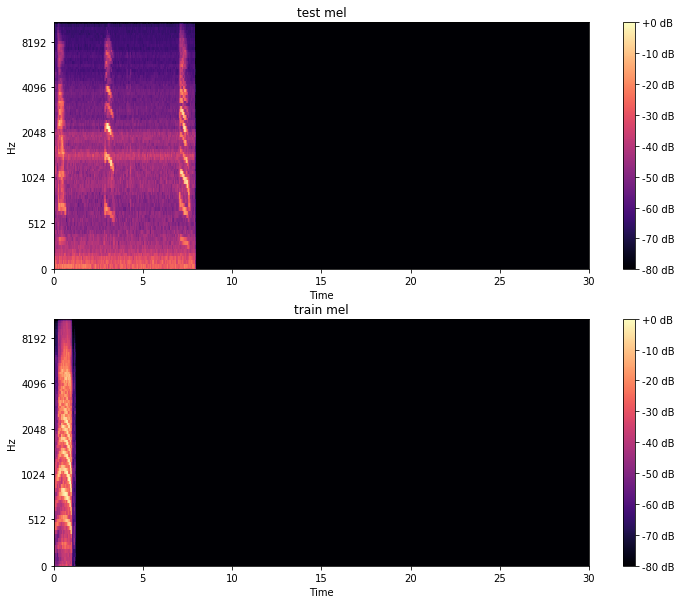

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
import librosa.display
plt.subplot(2, 1, 1)
librosa.display.specshow(test_mel['mel_spectrogram'], sr=16000, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('test mel')
plt.subplot(2, 1, 2)
librosa.display.specshow(train_mel['mel_spectrogram'], sr=16000, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('train mel')

/Users/vigi99/Library/Python/3.7/lib/python/site-packages/librosa/core/spectrum.py:1488: UserWarning: pcen was called on complex input so phase information will be discarded. To suppress this warning, call pcen(np.abs(D)) instead.
  warnings.warn('pcen was called on complex input so phase '


Text(0.5, 1.0, 'train pcen')

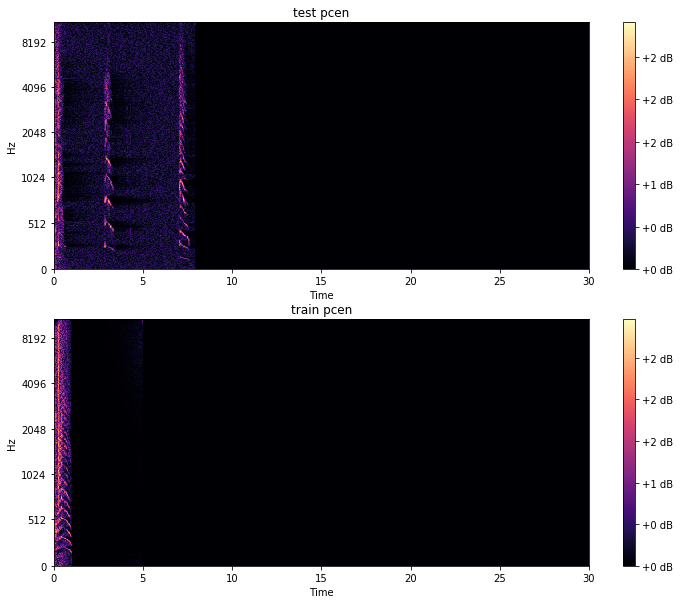

In [9]:
def pcen(stft):
    pcen_S = librosa.pcen(stft)
    return pcen_S

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
import librosa.display
plt.subplot(2, 1, 1)
librosa.display.specshow(pcen(test_mel['stft']), sr=16000, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('test pcen')
plt.subplot(2, 1, 2)
librosa.display.specshow(pcen(train_mel['stft']), sr=16000, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('train pcen')

Text(0.5, 1.0, 'train per cqt')

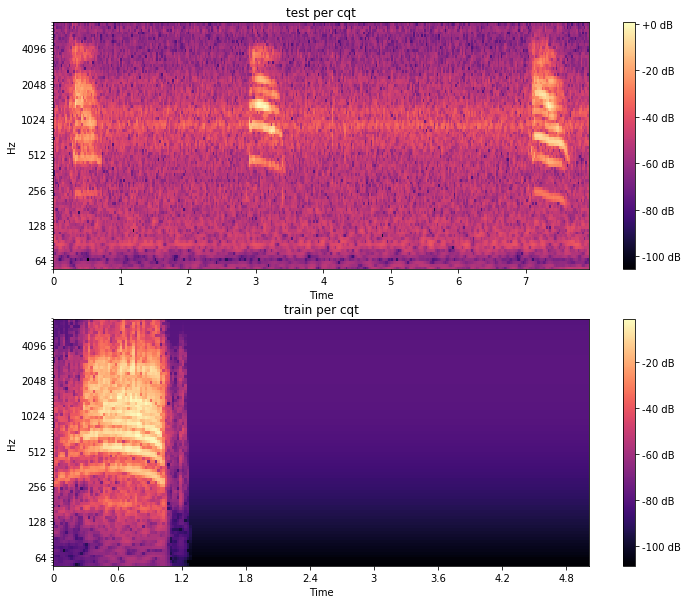

In [10]:
def per_cqt(path):
    y, sr = librosa.load(path)
    C = np.abs(librosa.cqt(y, sr=16000, fmin=librosa.note_to_hz('A1')))
    freqs = librosa.cqt_frequencies(C.shape[0], fmin=librosa.note_to_hz('A1'))
    perceptual_CQT = librosa.perceptual_weighting(C**2, freqs, ref=np.max)
    return perceptual_CQT

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
import librosa.display
plt.subplot(2, 1, 1)
librosa.display.specshow(per_cqt(test_mel['path']), fmin=librosa.note_to_hz('A1'), y_axis='cqt_hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('test per cqt')
plt.subplot(2, 1, 2)
librosa.display.specshow(per_cqt(train_mel['path']), fmin=librosa.note_to_hz('A1'), y_axis='cqt_hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('train per cqt')

In [11]:
from collections import Counter
samples = {}
for labels in t_train.labels.values:
    for label in labels.split(","):
        samples[label] = samples.get(label, 0) + 1
counter = Counter(samples)
counter.most_common()[-10:]

[('Sneeze', 53),
 ('Race_car_and_auto_racing', 51),
 ('Sigh', 50),
 ('Trickle_and_dribble', 49),
 ('Glockenspiel', 48),
 ('Buzz', 47),
 ('Mechanical_fan', 46),
 ('Accordion', 44),
 ('Fill_(with_liquid)', 42),
 ('Gasp', 41)]

(1105, 938)

ValueError: too many values to unpack (expected 2)

In [21]:
model = WideResNet(num_classes=80)
model(y)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 16 1 3, but got 3-dimensional input of size [1, 80, 938] instead